# U-Net training for Lake Detection

This notebook trains a lightweight U-Net segmentation model on a satellite image (`./notebooks/data/sattelite_lakes_example.jpg`) using automatically generated pseudo-labels (Otsu threshold), then postprocesses the predicted mask to extract connected-component bounding boxes. It saves the predicted mask, bounding boxes JSON, an overlay visualization, and the trained model weights.

Notes:
- No `try/except` is used. Errors will surface directly.
- Only minimal conditionals are used where necessary.
- Dependencies: `torch`, `torchvision`, `numpy`, `pillow`, `matplotlib`, `scikit-image`.
- Outputs are written to `outputs/unet/`.


In [11]:
import os
import json
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

device = (
    "cuda" if torch.cuda.is_available() else ("mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu")
)
print("Device:", device)

Device: mps


In [12]:
# Configure paths and hyperparameters
image_path = "./data/sattelite_lakes_example.jpg"
out_dir = "outputs/unet"
os.makedirs(out_dir, exist_ok=True)

patch_size = 256
stride = 128
batch_size = 8
epochs = 5
lr = 1e-3
min_region_area = 64  # pixels; filter extremely small regions in bbox extraction

Image shape: (1782, 2932) range: (9.0, 232.0)


Text(0.5, 1.0, 'Input LiDAR raster (normalized)')

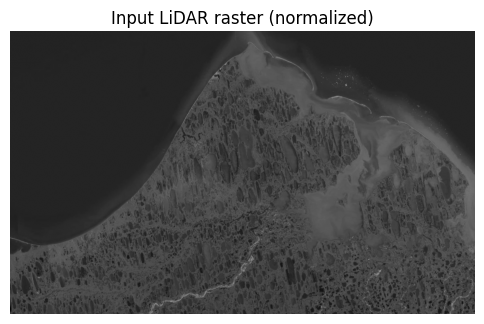

In [13]:
# Load LiDAR raster, convert to grayscale float32, and normalize to [0, 1]
img = Image.open(image_path).convert("L")
img_np = np.array(img).astype(np.float32)
vmin = float(img_np.min())
vmax = float(img_np.max())
rng = vmax - vmin
img_norm = (img_np - vmin) / (rng + 1e-8)

print("Image shape:", img_np.shape, "range:", (vmin, vmax))
plt.figure(figsize=(6,6))
plt.imshow(img_norm, cmap="gray")
plt.axis("off")
plt.title("Input LiDAR raster (normalized)")
# plt.show()

Otsu threshold: 0.228515625
Saved pseudo-label mask: outputs/unet/pseudo_label_mask.png


Text(0.5, 1.0, 'Pseudo-label mask')

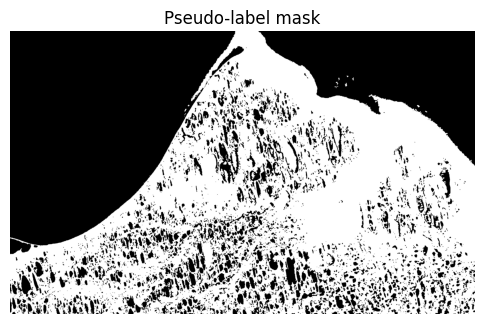

In [14]:
# Generate pseudo-label mask via Otsu threshold and simple morphology cleanup
th = float(filters.threshold_otsu(img_norm))
mask = img_norm > th
mask = morphology.remove_small_objects(mask, min_size=64)
mask = morphology.binary_opening(mask, morphology.disk(1))
mask = morphology.binary_closing(mask, morphology.disk(1))
mask_f = mask.astype(np.float32)

print("Otsu threshold:", th)
mask_path = os.path.join(out_dir, "pseudo_label_mask.png")
Image.fromarray((mask_f*255).astype(np.uint8)).save(mask_path)
print("Saved pseudo-label mask:", mask_path)
plt.figure(figsize=(6,6))
plt.imshow(mask_f, cmap="gray")
plt.axis("off")
plt.title("Pseudo-label mask")
# plt.show()

In [15]:
# Build patch dataset from image and mask
def extract_patches(img2d, msk2d, size=256, st=128):
    H, W = img2d.shape
    xs = []
    ys = []
    for y in range(0, max(H - size + 1, 0), st):
        for x in range(0, max(W - size + 1, 0), st):
            xs.append(img2d[y:y+size, x:x+size])
            ys.append(msk2d[y:y+size, x:x+size])
    if len(xs) == 0:
        pad_y = max(0, size - H)
        pad_x = max(0, size - W)
        if pad_y > 0 or pad_x > 0:
            img_pad = np.pad(img2d, ((0, pad_y), (0, pad_x)), mode="edge")
            msk_pad = np.pad(msk2d, ((0, pad_y), (0, pad_x)), mode="edge")
        else:
            img_pad = img2d
            msk_pad = msk2d
        xs.append(img_pad[0:size, 0:size])
        ys.append(msk_pad[0:size, 0:size])
    return np.stack(xs, 0), np.stack(ys, 0)

xs_np, ys_np = extract_patches(img_norm, mask_f, size=patch_size, st=stride)
print("Patches:", xs_np.shape)

class PatchDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        x_t = torch.from_numpy(x)[None, ...].float()  # [1,H,W]
        y_t = torch.from_numpy(y)[None, ...].float()  # [1,H,W]
        return x_t, y_t

dataset = PatchDataset(xs_np, ys_np)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print("Dataset size:", len(dataset))

Patches: (252, 256, 256)
Dataset size: 252


In [16]:
# Lightweight U-Net model definition
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad if necessary to handle odd sizes
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        if diffY != 0 or diffX != 0:
            x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.inc = DoubleConv(in_ch, base)
        self.down1 = Down(base, base*2)
        self.down2 = Down(base*2, base*4)
        self.down3 = Down(base*4, base*8)
        self.up1 = Up(base*8 + base*4, base*4)
        self.up2 = Up(base*4 + base*2, base*2)
        self.up3 = Up(base*2 + base, base)
        self.outc = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits

model = UNet(in_ch=1, out_ch=1, base=32).to(device)
print(model)

UNet(
  (inc): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (down2): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
# Losses, optimizer, and training loop
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(1,2,3))
    den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps
    return 1.0 - (num / den).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs + 1):
    total_loss = 0.0
    n_batches = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = bce(logits, yb) + dice_loss(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
        n_batches += 1
    avg = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch:02d}/{epochs} - loss: {avg:.4f}")

model_path = os.path.join(out_dir, "unet.pth")
torch.save(model.state_dict(), model_path)
print("Saved model:", model_path)

Epoch 01/5 - loss: 1.0503
Epoch 02/5 - loss: 0.5197
Epoch 03/5 - loss: 0.3662
Epoch 04/5 - loss: 0.3294
Epoch 05/5 - loss: 0.3164
Saved model: outputs/unet/unet.pth


Saved predicted mask: outputs/unet/pred_mask.png


(np.float64(-0.5), np.float64(2931.5), np.float64(1781.5), np.float64(-0.5))

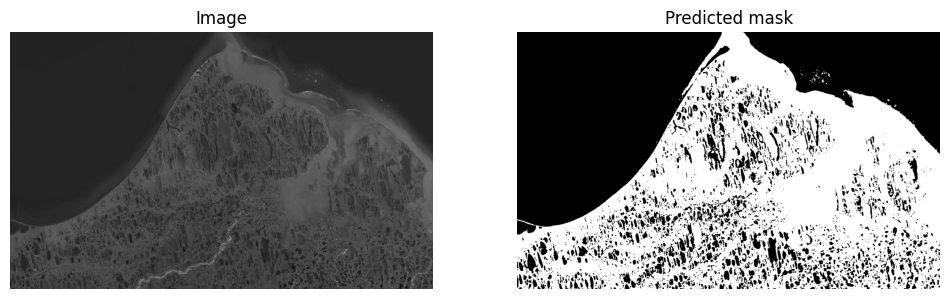

In [18]:
# Inference on full image with tiling and overlap-averaging
def predict_full_image(model, img2d, size=256, st=128, dev="cpu"):
    model.eval()
    H, W = img2d.shape
    pad_y = max(0, size - H)
    pad_x = max(0, size - W)
    if pad_y > 0 or pad_x > 0:
        img2d = np.pad(img2d, ((0, pad_y), (0, pad_x)), mode="edge")
    H2, W2 = img2d.shape
    ys = list(range(0, max(H2 - size + 1, 1), st))
    xs = list(range(0, max(W2 - size + 1, 1), st))
    if ys[-1] != H2 - size:
        ys.append(H2 - size)
    if xs[-1] != W2 - size:
        xs.append(W2 - size)
    prob_acc = np.zeros((H2, W2), dtype=np.float32)
    cnt_acc = np.zeros((H2, W2), dtype=np.float32)
    with torch.no_grad():
        for y in ys:
            for x in xs:
                patch = img2d[y:y+size, x:x+size]
                inp = torch.from_numpy(patch)[None, None, ...].float().to(dev)
                logits = model(inp)
                probs = torch.sigmoid(logits)[0, 0].cpu().numpy()
                prob_acc[y:y+size, x:x+size] += probs
                cnt_acc[y:y+size, x:x+size] += 1.0
    prob_full = prob_acc / np.maximum(cnt_acc, 1e-8)
    prob_full = prob_full[:H, :W]
    return prob_full

probs = predict_full_image(model, img_norm, size=patch_size, st=stride, dev=device)
pred_mask = (probs > 0.5).astype(np.uint8)

pred_mask_path = os.path.join(out_dir, "pred_mask.png")
Image.fromarray((pred_mask*255).astype(np.uint8)).save(pred_mask_path)
print("Saved predicted mask:", pred_mask_path)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img_norm, cmap="gray"); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(pred_mask, cmap="gray"); plt.title("Predicted mask"); plt.axis("off")
# plt.show()

Saved 44 boxes to: outputs/unet/bboxes.json
Saved overlay: outputs/unet/bboxes_overlay.png


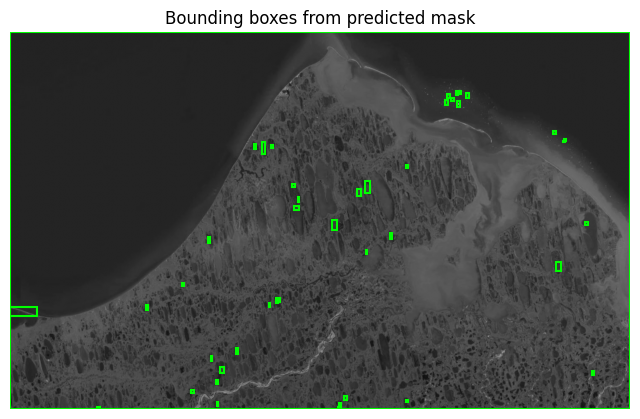

In [19]:
# Extract connected-component bounding boxes and save JSON + overlay visualization
labeled = measure.label(pred_mask, connectivity=1)
props = measure.regionprops(labeled)
boxes = []
for p in props:
    if p.area >= min_region_area:
        minr, minc, maxr, maxc = p.bbox  # rows (y), cols (x)
        w = maxc - minc
        h = maxr - minr
        boxes.append({
            "bbox_xyxy": [int(minc), int(minr), int(maxc), int(maxr)],
            "bbox_xywh": [int(minc), int(minr), int(w), int(h)],
            "area": int(p.area)
        })

bboxes_json = {
    "image": image_path,
    "mask_threshold": 0.5,
    "otsu": th,
    "bbox_formats": ["xyxy", "xywh"],
    "boxes": boxes
}
bbox_json_path = os.path.join(out_dir, "bboxes.json")
with open(bbox_json_path, "w", encoding="utf-8") as f:
    json.dump(bboxes_json, f, indent=2)
print(f"Saved {len(boxes)} boxes to:", bbox_json_path)

# Visualization overlay
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_norm, cmap="gray")
for b in boxes:
    x1, y1, x2, y2 = b["bbox_xyxy"]
    w = x2 - x1
    h = y2 - y1
    rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='lime', linewidth=1.5)
    ax.add_patch(rect)
ax.set_axis_off()
ax.set_title("Bounding boxes from predicted mask")
overlay_path = os.path.join(out_dir, "bboxes_overlay.png")
plt.savefig(overlay_path, bbox_inches="tight", pad_inches=0.0)
# plt.show()
print("Saved overlay:", overlay_path)

## Notes
- This example creates pseudo-labels automatically from the raster via Otsu thresholding, then trains a small U-Net to reproduce and refine them.
- Adjust `min_region_area`, `patch_size`, `stride`, and `epochs` for your data/compute.
- Outputs in `outputs/unet/`: `pseudo_label_mask.png`, `unet.pth`, `pred_mask.png`, `bboxes.json`, and `bboxes_overlay.png`.